In [90]:
%matplotlib inline
from time import sleep
import numpy as np 
import scipy
import os
import sys
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix

from random import randint
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.optimizers import RMSprop

from keras.layers.core import Dense, Dropout, Activation, Flatten


#Questions:
#question: Is there a better way to do the input than just flattening?


#Completed tasks
#Write a normal neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a deep neural net to try to predict the next measurement with the window method in multiple dimensions (train_baseline_multi)
#Write a Random Forest Regressor to try to predict the next measurement with the window method in multiple dimensions (train_forest)
#Consolidate the pipeline - shape data / create models / validate models 
#Sliding window with a RNN to predict the next value (train_window_regression_rnn)
#Random Forest Classifier to classify FLAG at the next measurement(30 trees, 30 features)
#Neural Network Classifier (1 layer, 512 nodes) 
#Deep Neural Network Classifier (2 layers, 512 nodes) 
#Recurrent Neural Network for classification using window
#Complete all the quizzes and submit a request for MIMIC
#Sanity check for A = B
    #If it doesn't work, make sure the rolling/unrolling is correct
    #Switch order of patient and timestep
    #If it still doesn't work, try only feeding it one previous instead of 20 previous
#Fix the regression
    #Make it so that the matrix predictor gives 0 error
    #Make the other regressors make sense
    #Make all the regressions work
#Make all the classifications work similarly
#Writeup: Regression where A \neq B
#Writeup: Regression where A = B
#Writeup: Classification 
#Sequence to sequence rnn classification
    #Get a 1-d version working DONE
    #Investigate what happens more closely by reducing the number of people to 2 DONE
    #Get a multiple dimension version working DONE
    
#--------------------------------------------------------------------------------------------------------------------------------------------
#/c/cs490/bin/abstract submit an abstract
# /c/cs490/bin/submit 
    #must have a top-level page named index.html;
    #should use only relative links for links between pages (they may be moved around); and
    #must include a copy of the description of the project as originally submitted at the start of the semester.
    #must include the final project report in PDF format.
    
#--------------------------------------------------------------------------------------------------------------------------------------------
#TODO 
#See how varying the sequence length affects regression in the case where A = B
#See how varying the sequence length affects regression in the case where A \neq B
#See how varying the sequence length affects binary classification

#Write the code to generate ternary classification
#Write the code to do ternary classification

#Figure out what we do if data is missing
#Implement it

#Steal the sequence to sequence rnn classification for ourselves
    #Go back to the toy example and make it work for larger dimensions
    #Bring it back to our synthetic data

#Investigate if any of our methods can actually predict in the time period where the flag is being flipped: e.g. the previous window has both 0 and 1
#Write a normal neural net to take prediction from rnn and predict 1/0
#Add a stateful try where the rnn is an autoencoder ( http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) and then another LSTM

In [91]:
# fix random seed for reproducibility
np.random.seed(7)
V=np.random.randn(10)
print(V.dot(V), np.linalg.norm(V)**2)

8.33980975239 8.33980975239


In [92]:
#Setup for the generation of the data 
d=10 ##number of measurements per patient per time unit
k=2 ##complexity of the time series
n=200 ## number of patients

len_sequence = 1
epochs = 25

T=175 ## amount of time measured for each patient (also batch size)
sigmaw=0.2##randomness
#d by d
U=np.random.randn(d,k).dot(np.random.randn(k,d))
betashift=np.random.randn(d)/np.sqrt(d)  ## used to check when we switch to the other time series
#normalized U
A=0.9*U/np.linalg.norm(U,ord=2)
#V is also d by d
V=np.random.randn(d,k).dot(np.random.randn(k,d))
#normalized V
B = .9*V/np.linalg.norm(V,ord=2) 
#B = A #Set B = A for sanity checking
X = np.zeros((n,T,d)) #this represents n patients, in d-dimensions, for T time-steps

flags = np.zeros((n,T)) 
flag = 1

In [93]:
#Generate the data, fill in X, Y, flags
for j in range(n): #for each patient
    X[j,0,:]=np.random.randn(d)/np.sqrt(d)
    flag=1
    flag_switch = -1
    for i in range(1,T): #for each time      
        if flag and ((X[j,i-1,:].dot(betashift))>.5): ##if flag was true and we go above a certain threshold, then set flag=0
            flag = 0
            flag_switch = i
        ## we can think of flag has flag==1 means not critical, flag==0 means critical
        if flag:
            flags[j,i] = 0
            X[j,i,:]=A.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
        else:
            flags[j,i] = 1
            X[j,i,:]=B.dot(X[j,i-1,:])+sigmaw*np.random.randn(d)
    #for i in range(0, T - len_sequence): #for each time
        #if(j == 2):
        #    print (flag_switch)
        #if flag_switch >= 0: #if the flag ever switched
        #    flags[j, i, :] = (flag_switch <= i + len_sequence) * np.ones(flags[j,i,:].shape) #set flags            
## X is a n by d by T tensor
## Y is just X but shifted one backwards
## n represents independent trials (think of them as patients or time periods for patients separated)
## T represents the time horizon (how long we observe a patient, for now T is the same for everybody, but we can imagine that changing)
## d is the number of measurements that we have per patient per time.
## flags are num_patients * num_timesteps * dimensionality

In [94]:
flags[3]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [95]:
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % T == 0:
            self.model.reset_states()
        self.counter += 1

In [96]:
print(X.shape)
print(flags.shape)
new_x = np.zeros((X.shape[0] * X.shape[1], 1, X.shape[2]))
for i in range(X.shape[0]):
    for ii in range(X.shape[1]):
        for iii in range(X.shape[2]):
            new_x[i * X.shape[1] + ii][0][iii] = X[i][ii][iii]
            
new_flags = np.zeros((X.shape[0] * X.shape[1], 1))
for i in range(flags.shape[0]):
    for ii in range(flags.shape[1]):
        new_flags[i * flags.shape[1] + ii][0] = flags[i][ii]

transition = 150
X_train = new_x[0: transition * X.shape[1]]
X_test = new_x[transition * X.shape[1]:X.shape[0]*X.shape[1]]
y_train = new_flags[0:transition*X.shape[1]]
y_test = new_flags[transition*X.shape[1]:X.shape[0]*X.shape[1]]

(200, 175, 10)
(200, 175)


In [97]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26250, 1, 10)
(26250, 1)
(8750, 1, 10)
(8750, 1)


In [158]:
# STATEFUL MODEL
print('Build STATEFUL model...')
model = Sequential()
model.add(LSTM(512,
               batch_input_shape=(1, 1, d), return_sequences=False,
               stateful=True))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Build STATEFUL model...


In [159]:
print(sum(y_train[:,0]))
print(y_train.shape)

7040.0
(26250, 1)


In [160]:
model.fit(X_train, y_train,
          callbacks=[ResetStatesCallback()],
      batch_size=1, nb_epoch=3,
          shuffle=False, validation_data=(X_test, y_test))


Train on 26250 samples, validate on 8750 samples
Epoch 1/3
26250/26250 [==============================] - 639s - loss: 0.8877 - acc: 0.9428 - val_loss: 12.9030 - val_acc: 0.1899
Epoch 2/3
26250/26250 [==============================] - 685s - loss: 0.2030 - acc: 0.9835 - val_loss: 10.7822 - val_acc: 0.1899
Epoch 3/3
26250/26250 [==============================] - 721s - loss: 0.2786 - acc: 0.9780 - val_loss: 11.4707 - val_acc: 0.1899


In [152]:
i = 0
j = 0
print(X_test[i * T + j:i * T + (j+1)].shape)
i = 8750
j = 750
print(X_test[i * T + j:i * T + (j+1)])
print(X_test.shape)

(1, 1, 10)
[]
(8750, 1, 10)


In [153]:
int(X_test.shape[0]/T)

50

In [165]:
y_preds_train = np.zeros(y_train.shape)
mean_tr_acc = []
mean_tr_loss = []
for i in range(int(X_train.shape[0]/T)):
    for j in range(T):
        tr_loss, tr_acc = model.test_on_batch(X_train[i * T + j:i * T + (j+1)], y_train[i*T + j])
        mean_tr_acc.append(tr_acc)
        mean_tr_loss.append(tr_loss)
    model.reset_states()
    
    for j in range(T):
        y_pred = model.predict_on_batch(X_train[i * T + j: i * T + j + 1])
        y_preds_train[i * T + j][0] = y_pred
    model.reset_states()
   

[[ 1660 17550]
 [   62  6978]]
0.329066666667


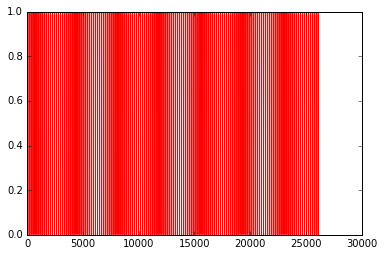

In [162]:
results = y_preds_train
results = results[:,0]
results = np.where(results>.5, 1, 0)
plt.plot(results, color='red')
confusion = confusion_matrix(y_train, results)
print(confusion)
correct = (confusion[0][0] + confusion[1][1])/(confusion[0][0] + confusion[0][1] + confusion[1][0] + confusion[1][1])
print(correct)

In [163]:
y_preds = np.zeros(y_test.shape)
mean_te_acc = []
mean_te_loss = []
for i in range(int(X_test.shape[0]/T)):
    for j in range(T):
        te_loss, te_acc = model.test_on_batch(X_test[i * T + j:i * T + (j+1)], y_test[i*T + j])
        mean_te_acc.append(te_acc)
        mean_te_loss.append(te_loss)
    model.reset_states()
    
    for j in range(T):
        y_pred = model.predict_on_batch(X_test[i * T + j: i * T + j + 1])
        y_preds[i * T + j][0] = y_pred
    model.reset_states()
   

[[ 569 6519]
 [  10 1652]]


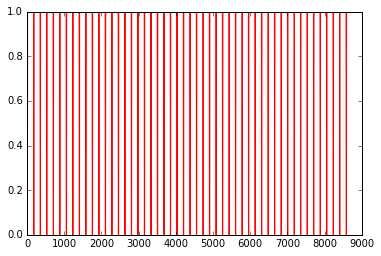

In [164]:
results = y_preds
results = results[:,0]
results = np.where(results>.5, 1, 0)
plt.plot(results, color='red')
print(confusion_matrix(y_test, results))

In [168]:
for i in range(500):
    print(results[i])

0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


26250/26250 [==============================] - 28s    
[[    0 19210]
 [    0  7040]]


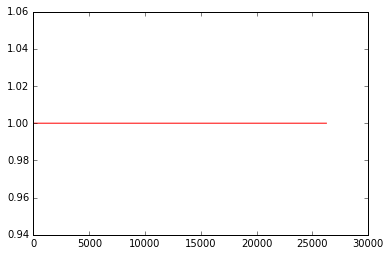

In [123]:
results = model.predict(X_train, batch_size=1, verbose=1)
results = results[:,0]
results = np.where(results>.5, 1, 0)
plt.plot(results, color='red')
print(confusion_matrix(y_train, results))